In [ ]:
from KPrincipalGaussiansClassifier import KPrincipalGaussiansClassifier, MetaParams
import pandas as pd

variance_perc_threshold=0.95
model_name = f"mahalanobis_class-specific_{ variance_perc_threshold * 100 }"
print("model name: ", model_name)

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

class_components_weights = [
    1, # 0
    1, # 1
    1, # 2
    1, # 3
    1, # 4
    1, # 5
    1, # 6
    1, # 7
    1, # 8
    1, # 9
]
train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
meta_params = MetaParams(
    num_classes=10,
    class_components_weights=class_components_weights,
     n_init=1,
    tol=1e-4,
    variance_perc_threshold=variance_perc_threshold,
    k_near_centroids=5
) 

k_prin_gauss_model = KPrincipalGaussiansClassifier(meta_params=meta_params)
k_prin_gauss_model.fit(train_data=train_data, labels=labels)


model name:  mahalanobis_class-specific_95.0
loading data
train shape: (42000, 784)
labels shape: (42000,)
PCA k_seg_por_classe: 154
Treinando GaussianMixture para a classe: 0
K componentes ideal para classe 0: 114
Initialization 0
Initialization converged. time lapse 8.12350s	 lower bound -14128154.71899.
Treinando GaussianMixture para a classe: 1
K componentes ideal para classe 1: 70
Initialization 0
Initialization converged. time lapse 9.33494s	 lower bound -10667168.81658.
Treinando GaussianMixture para a classe: 2
K componentes ideal para classe 2: 141
Initialization 0
Initialization converged. time lapse 7.80698s	 lower bound -14880558.19790.
Treinando GaussianMixture para a classe: 3
K componentes ideal para classe 3: 136
Initialization 0
Initialization converged. time lapse 6.20862s	 lower bound -14869931.59097.
Treinando GaussianMixture para a classe: 4
K componentes ideal para classe 4: 133
Initialization 0
Initialization converged. time lapse 7.51920s	 lower bound -14138662.

In [16]:
# Salvar modelo
import numpy as np
np.save(model_name, [k_prin_gauss_model], allow_pickle=True)

print(k_prin_gauss_model.class_components_weights)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


loading data
train shape: (42000, 784)
labels shape: (42000,)


100%|███████████████████████████████████| 42000/42000 [00:10<00:00, 4076.91it/s]

Precisão: 0.9761904761904762


'\nPodemos usar a matriz de confusão para atribuir um peso diferente para cada classe no momento da inferência e comparação das medidas\nSabendo quanto de erro tivemos de uma classificação com relação à outra, podemos aumentar ou diminuir a importância das gaussianas\nde uma classe com relação à outra \n'

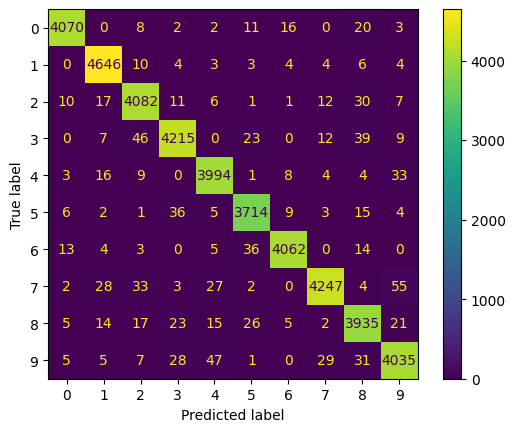

In [ ]:
# validar localmente
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)

loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = loaded_arr[0]
num_samples = 42000
validation_data = train_data[:num_samples,:]
labels_v = labels[:num_samples]
predictions = kgmm.predict(validation_data)
    
print("Precisão:", len(predictions[labels_v == predictions]) / num_samples)

# Compute confusion matrix
cm = confusion_matrix(labels_v, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

loading data
train shape: (42000, 784)
labels shape: (42000,)
Precisão: 0.9761904761904762


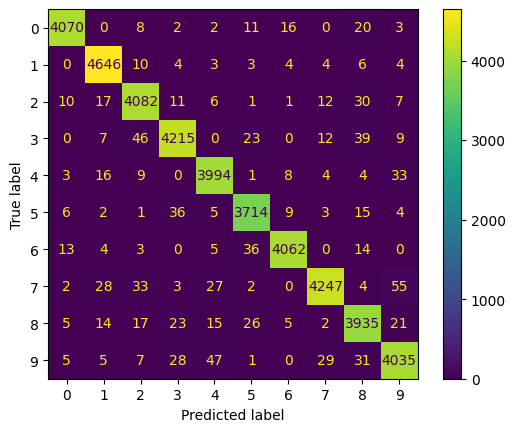

In [ ]:
''' 
  97.6 % de acerto nos dados de treino já é uma boa marca, mas esse valor pode melhorar.
  O grande problema é que as porcentagens de erro ocorrem quando há uma relação discreta e não linear que o nosso modelo não coneseguiu aprender.
  Aumentar o número de segmentos irá aumentar o tempo de treinamento e gerar overfitting.
  Para representar adequadamente essas relações não lineares entre as classes e permitir que nosso modelo tenha uma taxa maior de acerto, 
  ao invés de usarmos a menor distância de mahalanobis para determinar a resposta da classificação, iremos criar uma rede neural para 
  apreender estes relacionamentos. 
  
  Para conseguirmos fazer isso de forma eficiente no nosso contexto, buscaremos passar o mínimo de informações possíveis para a rede neural.
  Desta forma, o metaparâmetro mais relevante é o número de segmentos próximos retornados pela busca usando a distância euclidiana como método.
  precisamos saber qual é o k mínimo que encontra em todos os casos a gaussiana da classe correta, 
  ainda que ela possua uma distância de mahalanobis maior do que a classe que o modelo respondeu.
  
  Nesta célula encontraremos o número de k_segmentos_proximos a partir de um modelo de gaussianas pré treinado.
'''

# validar localmente
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from tqdm import tqdm
from search_optimization import find_closest_segments

def load_data(file_path): 
    print("loading data")
    all_data = pd.read_csv(file_path)
    train_data = all_data.to_numpy()[:, 1:]
    labels = all_data.to_numpy()[:, 0]
    print(f"train shape: {train_data.shape}")
    print(f"labels shape: {labels.shape}")
    
    return train_data, labels

train_data_file_path = 'C:/src/data_analysis/data/digit-recognizer/train.csv'
train_data, labels = load_data(train_data_file_path)
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgmm = KPrincipalGaussiansClassifier(loaded_arr[0]) 
num_samples = 42000
validation_data = train_data[:num_samples,:]
labels_v = labels[:num_samples]

MetaParams = MetaParams(
  k_near_centroids = 1
)
for idx in tqdm(range(len(train_data)), ncols=80, colour="blue"): 
  hnsw = kgmm.hnsw
  point = validation_data[idx]
  label = labels_v[idx]
  find_closest_segments(hnsw=hnsw, point=point, metaparams=self.meta_params) 
  
    
print("Precisão:", len(predictions[labels_v == predictions]) / num_samples)

# Compute confusion matrix
cm = confusion_matrix(labels_v, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [14]:
''' Gerar submissão '''
loaded_arr = np.load(f'{model_name}.npy', allow_pickle=True)

kgm = loaded_arr[0]  
file_path = '../data/digit-recognizer/test.csv' 
test_data = pd.read_csv(file_path)
data_points = test_data.to_numpy()
 
test_data.loc[:, "Label"] = kgm.predict(data_points).astype(int)
answer = test_data[["Label"]].copy() 
answer["ImageId"] = range(1, len(answer) + 1)  
answer = answer[["ImageId", "Label"]]

# Save to CSV
output_file = f"{model_name}.csv"
answer.to_csv(output_file, index=False)

100%|███████████████████████████████████| 28000/28000 [00:09<00:00, 2905.72it/s]
